In [7]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time
from joblib import dump


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score, classification_report

os.chdir("../lib")
import titanic_functions as tfunc

np.set_printoptions(suppress=True)

In [3]:
os.chdir("../dataset")
#os.getcwd()

In [18]:
raw_df = pd.read_csv("../dataset/titanic_data.csv")
raw_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [19]:
# Create a df copy to transform and manipulate
df = raw_df.copy()

In [6]:
# Drop "boat", "body", "home.dest" and "ticket". The first two hold information if the passenger survived (boat) or if it didn't and the body was recovered (body).
df = df.drop(["boat", "body", "home.dest", "ticket"], axis=1)
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'cabin', 'embarked'],
      dtype='object')

In [6]:
# Check dtypes
df.dtypes

pclass        int64
survived      int64
name         object
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
cabin        object
embarked     object
dtype: object

In [7]:
df.describe()

,pclass,survived,age,sibsp,parch,fare
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200


In [8]:
# sex could be dummy var
# ticket?
# fare 0?

In [9]:
print("There are {} observations with fare equal to 0.".format(df["fare"][df["fare"]==0].count()))

There are 17 observations with fare equal to 0.


##### EDA

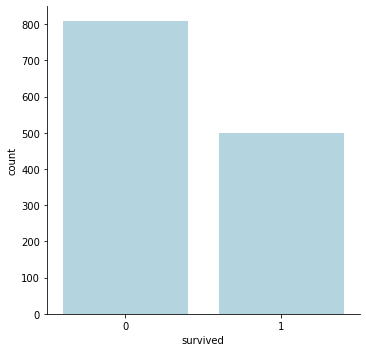

In [10]:
sns.catplot(x="survived", kind="count", color="lightblue", data=df);

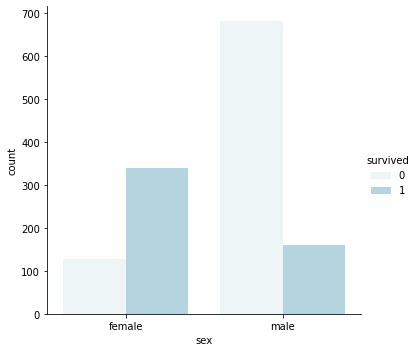

In [11]:
sns.catplot(x="sex", hue="survived", kind="count", color="lightblue", data=df);

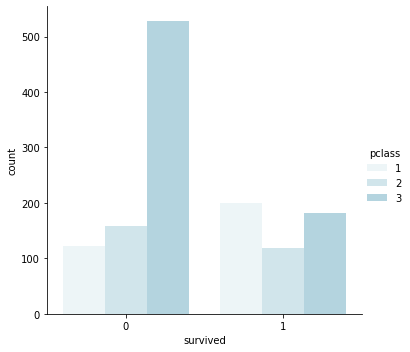

In [12]:
sns.catplot(x="survived", hue="pclass", kind="count", color="lightblue", data=df);

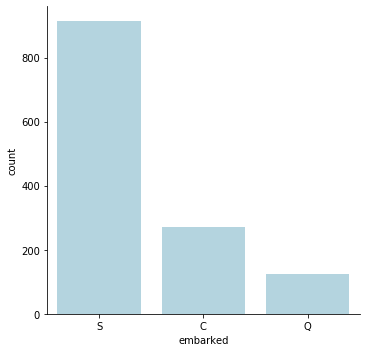

In [13]:
sns.catplot(x="embarked", kind="count", color="lightblue", data=df);

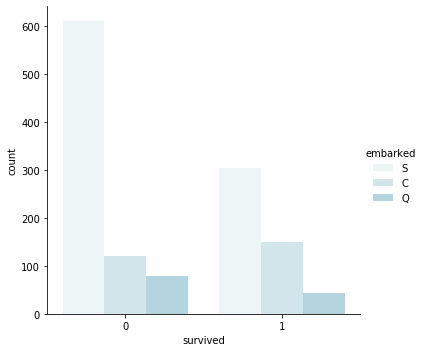

In [14]:
sns.catplot(x="survived", hue="embarked", kind="count", color="lightblue", data=df);

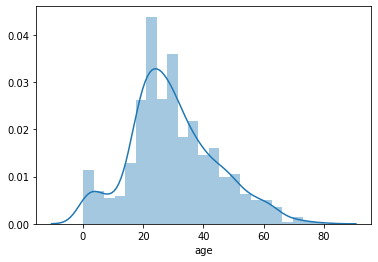

In [15]:
sns.distplot(df["age"]);

In [16]:
female_mean_age = int(round(df["age"][(df["sex"]=="female")].mean(),0))
male_mean_age = int(round(df["age"][(df["sex"]=="male")].mean(),0))
print("Average female age: {}".format(female_mean_age))
print("Average male age: {}".format(male_mean_age))

Average female age: 29
Average male age: 31


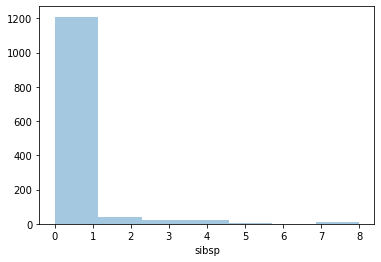

In [17]:
bins = len(df["sibsp"].unique())
sns.distplot(df["sibsp"], bins=bins, kde=False);

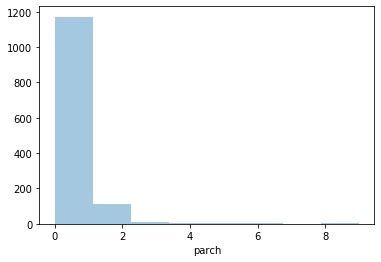

In [18]:
bins = len(df["parch"].unique())
sns.distplot(df["parch"], bins=bins, kde=False);

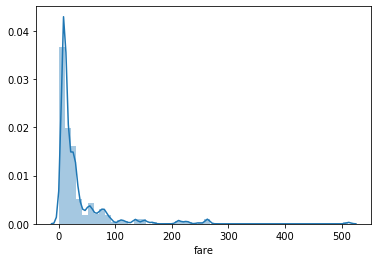

In [19]:
sns.distplot(df["fare"]);

In [20]:
fare_log = df["fare"][(df["fare"]!=0)]
fare_log = np.log10(fare_log)

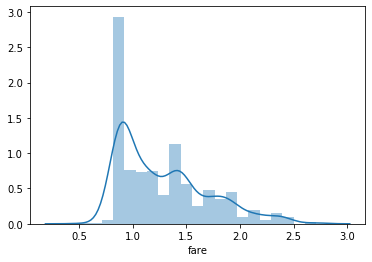

In [21]:
sns.distplot(fare_log);

In [22]:
# NULL values

# Create a list of features containing null or blanks, splitted by numerical values and text/objects.

value_col = []
text_col = []

if df.isnull().values.any():
    for col in df.columns:    
            if df[col].count() < df.shape[0]: #Comparing each column with total number of rows
                n_nan = df.shape[0] - df[col].count()
                print('Count of NULL in {} ({}): {}'.format(col.upper(),df[col].dtype, f"{n_nan:,}"))

                if df[col].dtype in ('float64', 'int64'):
                    value_col.append(col)
                if df[col].dtype == 'object':
                    text_col.append(col)
else:
    print("No NULL values in the dataframe")



Count of NULL in AGE (float64): 263
Count of NULL in FARE (float64): 1
Count of NULL in CABIN (object): 1,014
Count of NULL in EMBARKED (object): 2


In [7]:
# Just a few observations, drop them

df.drop(df[(pd.isnull(df["fare"]))].index, inplace=True)
df.drop(df[(pd.isnull(df["embarked"]))].index, inplace=True)

In [8]:
# Quick replace with median
df["age"].fillna(df["age"].median(), inplace=True)

In [25]:
# We will deal with CABIN later on

# Data Processing

In [9]:
# from: https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/

# Extract titles
df["title"] = df["name"].str.extract(r'(Mrs|Mr|Master|Miss|Major|Rev|Dr|Ms|Mlle|Col|Capt|Mme|Countess|Don|Jonkheer)')

# Replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
df['title']=df.apply(replace_titles, axis=1)
df.drop("name", axis=1, inplace=True)

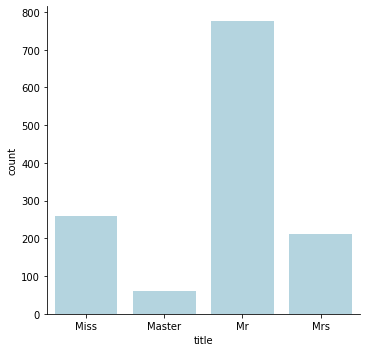

In [10]:
sns.catplot(x="title", kind="count", color="lightblue", data=df);

In [11]:
df['deck'] = df["cabin"].str[0].fillna("Unknown")
df.drop("cabin", axis=1, inplace=True)

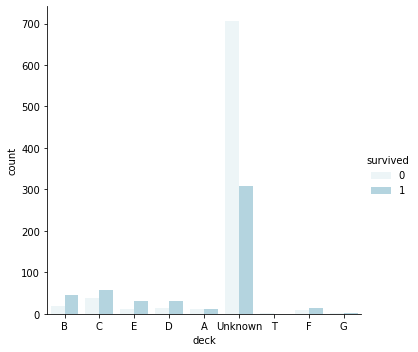

In [12]:
sns.catplot(x="deck", hue="survived", kind="count", color="lightblue", data=df);

In [13]:
#Creating new family_size column
df['family_size'] = df['sibsp']+df['parch'] + 1 #counting the passenger itself
df['fare_per_person'] = df['fare']/df['family_size']
df['alone'] = df['family_size'].apply(lambda x: 1 if x==1 else 0)

In [31]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,deck,family_size,fare_per_person,alone
0,1,1,female,29.00,0,0,211.3375,S,Miss,B,1,211.3375,1
1,1,1,male,0.92,1,2,151.5500,S,Master,C,4,37.8875,0
2,1,0,female,2.00,1,2,151.5500,S,Miss,C,4,37.8875,0
3,1,0,male,30.00,1,2,151.5500,S,Mr,C,4,37.8875,0
4,1,0,female,25.00,1,2,151.5500,S,Mrs,C,4,37.8875,0


In [14]:
df['age*class'] = df['age']*df['pclass']

In [33]:
df.dtypes

pclass               int64
survived             int64
sex                 object
age                float64
sibsp                int64
parch                int64
fare               float64
embarked            object
title               object
deck                object
family_size          int64
fare_per_person    float64
alone                int64
age*class          float64
dtype: object

In [34]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,deck,family_size,fare_per_person,alone,age*class
0,1,1,female,29.00,0,0,211.3375,S,Miss,B,1,211.3375,1,29.00
1,1,1,male,0.92,1,2,151.5500,S,Master,C,4,37.8875,0,0.92
2,1,0,female,2.00,1,2,151.5500,S,Miss,C,4,37.8875,0,2.00
3,1,0,male,30.00,1,2,151.5500,S,Mr,C,4,37.8875,0,30.00
4,1,0,female,25.00,1,2,151.5500,S,Mrs,C,4,37.8875,0,25.00


In [15]:
df2 = pd.get_dummies(df, columns=["sex", "embarked", "title", "deck"], dummy_na=True, prefix="dummy")

In [36]:
df2.head()

,pclass,survived,age,sibsp,parch,fare,family_size,fare_per_person,alone,age*class,...,dummy_A,dummy_B,dummy_C,dummy_D,dummy_E,dummy_F,dummy_G,dummy_T,dummy_Unknown,dummy_nan
0,1,1,29.00,0,0,211.3375,1,211.3375,1,29.00,...,0,1,0,0,0,0,0,0,0,0
1,1,1,0.92,1,2,151.5500,4,37.8875,0,0.92,...,0,0,1,0,0,0,0,0,0,0
2,1,0,2.00,1,2,151.5500,4,37.8875,0,2.00,...,0,0,1,0,0,0,0,0,0,0
3,1,0,30.00,1,2,151.5500,4,37.8875,0,30.00,...,0,0,1,0,0,0,0,0,0,0
4,1,0,25.00,1,2,151.5500,4,37.8875,0,25.00,...,0,0,1,0,0,0,0,0,0,0


In [37]:
df2.dtypes

pclass               int64
survived             int64
age                float64
sibsp                int64
parch                int64
fare               float64
family_size          int64
fare_per_person    float64
alone                int64
age*class          float64
dummy_female         uint8
dummy_male           uint8
dummy_nan            uint8
dummy_C              uint8
dummy_Q              uint8
dummy_S              uint8
dummy_nan            uint8
dummy_Master         uint8
dummy_Miss           uint8
dummy_Mr             uint8
dummy_Mrs            uint8
dummy_nan            uint8
dummy_A              uint8
dummy_B              uint8
dummy_C              uint8
dummy_D              uint8
dummy_E              uint8
dummy_F              uint8
dummy_G              uint8
dummy_T              uint8
dummy_Unknown        uint8
dummy_nan            uint8
dtype: object

In [16]:
### CHECK ###
# Checking if there are any more null values in the dataset. Print the column name if it contains nulls.

if df2.isnull().values.any():
    for col in df2.columns:    
        if df2[col].count() < df2.shape[0]: #Comparing each column with total number of rows
            n_nan = df2.shape[0] - df2[col].count()
            print('Count of NULL in {} ({}): {}'.format(col.upper(),df2[col].dtype, f"{n_nan:,}"))

else:
    print("No NULL values in the dataframe")

No NULL values in the dataframe


In [39]:
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,deck,family_size,fare_per_person,alone,age*class
0,1,1,female,29.00,0,0,211.3375,S,Miss,B,1,211.3375,1,29.00
1,1,1,male,0.92,1,2,151.5500,S,Master,C,4,37.8875,0,0.92
2,1,0,female,2.00,1,2,151.5500,S,Miss,C,4,37.8875,0,2.00
3,1,0,male,30.00,1,2,151.5500,S,Mr,C,4,37.8875,0,30.00
4,1,0,female,25.00,1,2,151.5500,S,Mrs,C,4,37.8875,0,25.00


# Modelling

In [45]:
X = df2.drop("survived", axis=1)
y = df2["survived"]

In [60]:
# Cross-Validation
# scalerCV = StandardScaler()
# XCV = scalerCV.fit_transform(X)

# warnings.filterwarnings(action='ignore')

# models = {"Logistic Regression":LogisticRegression(), "SVC":SVC(), "Random Forest Classifier":RandomForestClassifier()}
# scoring = ["accuracy", "balanced_accuracy", "precision", "recall", "roc_auc", "f1"]
# models_results = {}

# print("-"*20)
# for m in models:
#     print("Starting CV for {}".format(m))
#     start = time.time()
#     stratkfold = StratifiedKFold(n_splits=100, shuffle=True, random_state=42)
#     model = models[m]
#     results = cross_validate(model, XCV, y, cv=stratkfold, scoring=scoring, error_score=0)
#     models_results[m] = results
#     run_time = round(time.time() - start,1)
#     print("Finished in {} seconds".format(run_time))
#     print("-"*20)
    
# warnings.filterwarnings(action='default')

--------------------
Starting CV for Logistic Regression
Finished in 1.1 seconds
--------------------
Starting CV for SVC
Finished in 4.5 seconds
--------------------
Starting CV for Random Forest Classifier
Finished in 16.4 seconds
--------------------


In [61]:
# for m in models_results.keys():
#     print("Test results for {}:".format(m))
#     print("    ROC AUC average: {}".format(np.round(models_results[m]["test_roc_auc"].mean(),4)))
#     print("    Recall: {}".format(np.round(models_results[m]["test_recall"].mean(),4)))
#     print("    F1-Score: {}".format(np.round(models_results[m]["test_f1"].mean(),4)))
#     print()

Test results for Logistic Regression:
    ROC AUC average: 0.8509
    Recall: 0.736
    F1-Score: 0.7351

Test results for SVC:
    ROC AUC average: 0.8408
    Recall: 0.732
    F1-Score: 0.7358

Test results for Random Forest Classifier:
    ROC AUC average: 0.846
    Recall: 0.6935
    F1-Score: 0.703



### Param tunning

In [318]:
# Code adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

# Split the dataset in two equal parts
X_trainCV, X_testCV, y_trainCV, y_testCV = train_test_split(X, y, test_size=0.2, random_state=0)

scalerParam = StandardScaler()

X_trainParam = scalerParam.fit_transform(X_trainCV)
#X_trainParam = scalerParam.transform(X_trainCV)
X_testParam = scalerParam.transform(X_testCV)


# Set the parameters by cross-validation
#tuned_parameters = {'penalty': ["l2", "l1", "none"], "C": [0.001,0.01,0.1,1,10,100,1000], "class_weight":["balanced"]}

# Number of trees in random forest
n_estimators = [30, 40, 50, 100, 200, 400]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [5, 8, 15, 25, 50, 100, 200]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
tuned_parameters = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


print("# Tuning hyper-parameters")
print()

clf = GridSearchCV(RandomForestClassifier(n_jobs=-1), tuned_parameters)
clf.fit(X_trainParam, y_trainCV)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_testCV, clf.predict(X_testParam)
print(classification_report(y_true, y_pred))
print()

# Tuning hyper-parameters

Best parameters set found on development set:

{'bootstrap': True, 'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 40}

Grid scores on development set:

0.804 (+/-0.054) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 30}
0.804 (+/-0.071) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
0.799 (+/-0.051) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
0.807 (+/-0.059) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
0.807 (+/-0.055) for {'bootstrap': True, 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
0.806 (+/-0.058) for 

              precision    recall  f1-score   support

           0       0.83      0.92      0.88       157
           1       0.86      0.72      0.79       105

    accuracy                           0.84       262
   macro avg       0.85      0.82      0.83       262
weighted avg       0.85      0.84      0.84       262




In [348]:
best_params_rfc = clf.best_params_

In [352]:
best_params_rfc
# {'bootstrap': True,
#  'max_depth': 25,
#  'max_features': 'auto',
#  'min_samples_leaf': 4,
#  'min_samples_split': 10,
#  'n_estimators': 40}

{'bootstrap': True,
 'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 40}

In [321]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [344]:
# From the internet
rfc = RandomForestClassifier(n_jobs=-1,
                             bootstrap=best_params["bootstrap"],
                             max_depth=best_params["max_depth"],
                             max_features=best_params[ "max_features"],
                             min_samples_leaf=best_params["min_samples_leaf"],
                             min_samples_split=best_params["min_samples_split"],
                             n_estimators=best_params[ "n_estimators"])

In [345]:
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)

0.8601532567049809

In [346]:
y_pred = rfc.predict(X_test)
y_pred_probs = rfc.predict_proba(X_test)

Accuracy: 0.8435
Precision: 0.8636
Recall: 0.7238
--------------------

Confusion Matrix


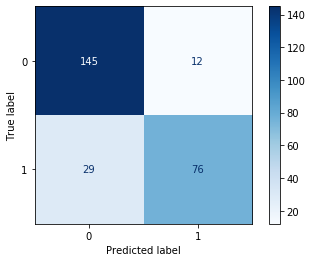

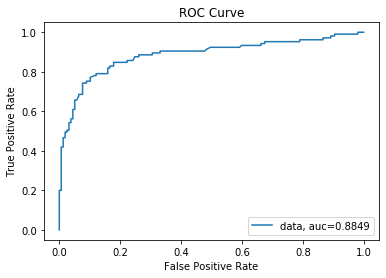

In [347]:
#Results
#print("Confusion Matrix:\n", confusion_matrix(y_test_under, y_pred_under))    
print("Accuracy:", np.round(accuracy_score(y_test, y_pred),4))
print("Precision:", np.round(precision_score(y_test, y_pred),4))
print("Recall:", np.round(recall_score(y_test, y_pred),4))
print("-"*20)
print()
print("Confusion Matrix")
plot_confusion_matrix(rfc, X_test, y_test, values_format=".5g", cmap="Blues");


#ROC Curve
y_pred_proba = y_pred_probs[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr,tpr,label="data, auc="+str(np.round(auc,4)));
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4);
#plt.show()

# New Modelling

In [2]:
df2 = pd.read_csv("../dataset/titanic_data.csv")
df2 = tfunc.clean_df(df2)

NameError: name 'tfunc' is not defined

In [6]:
X = df2.drop("survived", axis=1)
y = df2["survived"]

In [7]:
df2.iloc[1].values

array([  1.    ,   1.    ,   0.92  ,   1.    ,   2.    , 151.55  ,
         4.    ,  37.8875,   0.    ,   0.92  ,   0.    ,   1.    ,
         0.    ,   0.    ,   1.    ,   1.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   1.    ,   0.    ,   0.    ,
         0.    ,   0.    ,   0.    ,   0.    ])

In [8]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
gnb = GaussianNB()

In [10]:
best_params_rfc = {'bootstrap': True,
                   'max_depth': 25,
                   'max_features': 'auto',
                   'min_samples_leaf': 4,
                   'min_samples_split': 10,
                   'n_estimators': 40}

rfc = RandomForestClassifier(n_jobs=-1,
                             bootstrap=best_params_rfc["bootstrap"],
                             max_depth=best_params_rfc["max_depth"],
                             max_features=best_params_rfc[ "max_features"],
                             min_samples_leaf=best_params_rfc["min_samples_leaf"],
                             min_samples_split=best_params_rfc["min_samples_split"],
                             n_estimators=best_params_rfc[ "n_estimators"])

In [11]:
best_params_lr = {'C': 0.01,
                  'class_weight': 'None',
                  'fit_intercept': True,
                  'max_iter': 50,
                  'penalty': 'l2'}

lr = LogisticRegression(n_jobs=-1,
                       C=best_params_lr["C"],
                       class_weight=best_params_lr["class_weight"],
                       fit_intercept=best_params_lr["fit_intercept"],
                       max_iter=best_params_lr["max_iter"],
                       penalty=best_params_lr["penalty"])


In [12]:
svc = SVC(probability=True)

In [13]:
models = {"Gaussian Naive Bayes":gnb,
          "Random Forest Classifier":rfc,
          "Logistic Regression":lr,
          "Support Vector Classifier":svc}

for m in models:
    model = models[m]
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)
    auc = round(roc_auc_score(y_test, y_pred_proba[::,1]),4)
    print("{} AUC: {}".format(m, auc))

Gaussian Naive Bayes AUC: 0.7912
Random Forest Classifier AUC: 0.8784
Logistic Regression AUC: 0.8649
Support Vector Classifier AUC: 0.8672


Accuracy: 0.8053
Precision: 0.72
Recall: 0.8491
--------------------

Confusion Matrix


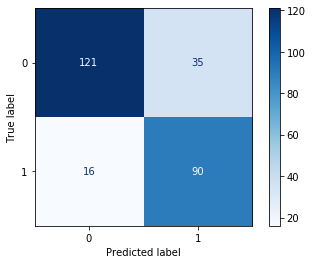

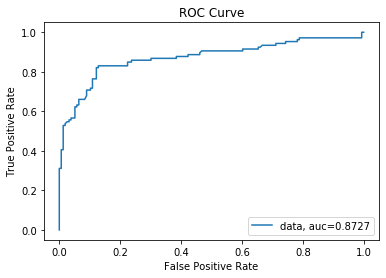

In [14]:
# Voting Classifier Testing

estimators = [("Gaussian Naive Bayes", gnb),
              ("Random Forest Classifier", rfc),
              ("Logistic Regression", lr),
              ("Support Vector Classifier", svc)]

vc = VotingClassifier(estimators=estimators, voting='soft')
vc.fit(X_train, y_train)
vc_pred = vc.predict(X_test)
vc_pred_probs = vc.predict_proba(X_test)

#Results
#print("Confusion Matrix:\n", confusion_matrix(y_test_under, y_pred_under))    
print("Accuracy:", np.round(accuracy_score(y_test, vc_pred),4))
print("Precision:", np.round(precision_score(y_test, vc_pred),4))
print("Recall:", np.round(recall_score(y_test, vc_pred),4))
print("-"*20)
print()
print("Confusion Matrix")
plot_confusion_matrix(vc, X_test, y_test, values_format=".5g", cmap="Blues");

#ROC Curve
y_pred_proba = vc_pred_probs[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr,tpr,label="data, auc="+str(np.round(auc,4)));
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4);
#plt.show()

# Re-training

In [4]:
# Import
df2 = pd.read_csv("../dataset/titanic_data.csv")
df2 = tfunc.clean_df(df2)

In [8]:
# Split and transform input
sc = StandardScaler()

X = df2.drop("survived", axis=1)
sc.fit(X)
X = sc.transform(X)

y = df2["survived"]

In [6]:
# Models

gnb = GaussianNB()

svc = SVC(probability=True)

best_params_rfc = {'bootstrap': True,
                   'max_depth': 25,
                   'max_features': 'auto',
                   'min_samples_leaf': 4,
                   'min_samples_split': 10,
                   'n_estimators': 40}

rfc = RandomForestClassifier(n_jobs=-1,
                             bootstrap=best_params_rfc["bootstrap"],
                             max_depth=best_params_rfc["max_depth"],
                             max_features=best_params_rfc[ "max_features"],
                             min_samples_leaf=best_params_rfc["min_samples_leaf"],
                             min_samples_split=best_params_rfc["min_samples_split"],
                             n_estimators=best_params_rfc[ "n_estimators"])

best_params_lr = {'C': 0.01,
                  'class_weight': 'None',
                  'fit_intercept': True,
                  'max_iter': 50,
                  'penalty': 'l2'}

lr = LogisticRegression(n_jobs=-1,
                       C=best_params_lr["C"],
                       class_weight=best_params_lr["class_weight"],
                       fit_intercept=best_params_lr["fit_intercept"],
                       max_iter=best_params_lr["max_iter"],
                       penalty=best_params_lr["penalty"])

In [7]:
# Voting Classifier Production

estimators = [("Gaussian Naive Bayes", gnb),
              ("Random Forest Classifier", rfc),
              ("Logistic Regression", lr),
              ("Support Vector Classifier", svc)]

vc_prod = VotingClassifier(estimators=estimators, voting='soft')
vc_prod.fit(X, y)

VotingClassifier(estimators=[('Gaussian Naive Bayes',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('Random Forest Classifier',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=25,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=4,
              

In [23]:
from joblib import load
model = load('../modelling/outcomes/voting_classifier_titanic.joblib')
sc = load("../modelling/outcomes/scaler.joblib")

In [65]:
import pandas as pd
import numpy as np
import os

os.chdir("../lib")
import titanic_functions as tfunc

df = pd.read_csv("../dataset/titanic_data.csv").drop(["boat", "body", "home.dest", "ticket"], axis=1)
df2 = tfunc.clean_df(df)


In [66]:
df2[(df2["survived"]==True)].head()

,pclass,survived,age,sibsp,parch,fare,family_size,fare_per_person,alone,age*class,...,dummy_Mrs,dummy_A,dummy_B,dummy_C,dummy_D,dummy_E,dummy_F,dummy_G,dummy_T,dummy_Unknown
0,1,1,29.00,0,0,211.3375,1,211.337500,1,29.00,...,0,0,1,0,0,0,0,0,0,0
1,1,1,0.92,1,2,151.5500,4,37.887500,0,0.92,...,0,0,0,1,0,0,0,0,0,0
5,1,1,48.00,0,0,26.5500,1,26.550000,1,48.00,...,0,0,0,0,0,1,0,0,0,0
6,1,1,63.00,1,0,77.9583,2,38.979150,0,63.00,...,0,0,0,0,1,0,0,0,0,0
8,1,1,53.00,2,0,51.4792,3,17.159733,0,53.00,...,1,0,0,1,0,0,0,0,0,0


In [67]:
df.dtypes

pclass               int64
survived             int64
sex                 object
age                float64
sibsp                int64
parch                int64
fare               float64
embarked            object
title               object
deck                object
family_size          int64
fare_per_person    float64
alone                int64
age*class          float64
dtype: object

In [26]:
test = df2.drop(["survived"], axis=1).iloc[7]

In [27]:
test.values

array([ 1., 39.,  0.,  0.,  0.,  1.,  0.,  1., 39.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.])

In [28]:
test.shape

(27,)

In [29]:
#test = tfunc.process_single_input([test])
test = sc.transform(test.values.reshape(1,-1))

In [46]:
pytest = np.array([[-1.55011801,  0.73995717, -0.47953739, -0.44540733, -0.64199223, -0.55890642,
  -0.57207875,  0.81155988, -0.79146312,  1.34789107, -1.34789107,  1.95978079,
  -0.32231217, -1.52502451,  4.55887413, -0.49712916, -1.21080045, -0.43876901,
   7.64258405, -0.22504019, -0.27837711, -0.19099472, -0.17995962, -0.12778773,
  -0.06196972, -0.02767123, -1.86030934]])

In [58]:
test[0][0]

-1.5501180117967508

In [57]:
pytest[0][0]

-1.55011801

In [56]:
test == pytest

array([[False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False]])

In [60]:
list(test[0])

[-1.5501180117967508,
 0.7399571673050869,
 -0.4795373947471247,
 -0.4454073347677332,
 -0.6419922324151165,
 -0.5589064159532368,
 -0.5720787475444739,
 0.8115598817243035,
 -0.7914631218754933,
 -0.7418997128097174,
 0.7418997128097173,
 -0.5102611504500716,
 -0.3223121703180553,
 0.6557271674728183,
 -0.21935240401041511,
 -0.4971291628743507,
 0.8258999225757816,
 -0.43876901460242435,
 7.642584046583388,
 -0.22504018933674994,
 -0.27837711289308165,
 -0.19099472488158722,
 -0.17995962334578036,
 -0.12778773223634915,
 -0.06196971660197945,
 -0.027671226645624283,
 -1.860309343427141]

In [30]:
model.predict(test)

array([0], dtype=int64)

In [33]:
vc_prod.predict(test.reshape(1,-1))

NameError: name 'vc_prod' is not defined

In [8]:
test

array([[-1.55011801,  0.73995717, -0.47953739, -0.44540733, -0.64199223,
        -0.55890642, -0.57207875,  0.81155988, -0.79146312, -0.74189971,
         0.74189971, -0.51026115, -0.32231217,  0.65572717, -0.2193524 ,
        -0.49712916,  0.82589992, -0.43876901,  7.64258405, -0.22504019,
        -0.27837711, -0.19099472, -0.17995962, -0.12778773, -0.06196972,
        -0.02767123, -1.86030934]])

In [9]:
model.predict_proba(test.reshape(1, -1))

array([[0.16613146, 0.83386854]])

In [21]:
dump(vc_prod, filename="../modelling/outcomes/voting_classifier_titanic.joblib")

['../modelling/outcomes/voting_classifier_titanic.joblib']

In [22]:
dump(sc, filename="../modelling/outcomes/scaler.joblib")

['../modelling/outcomes/scaler.joblib']

# Kaggle Test

In [17]:
# Re-train with all data

sc_k = StandardScaler()

X_k = df2.drop("survived", axis=1)
X_k = sc_k.fit_transform(X_k)

y_k = df2["survived"]

vc_k = VotingClassifier(estimators=estimators, voting='soft')
vc_k.fit(X_k, y_k)

VotingClassifier(estimators=[('Gaussian Naive Bayes',
                              GaussianNB(priors=None, var_smoothing=1e-09)),
                             ('Random Forest Classifier',
                              RandomForestClassifier(bootstrap=True,
                                                     ccp_alpha=0.0,
                                                     class_weight=None,
                                                     criterion='gini',
                                                     max_depth=25,
                                                     max_features='auto',
                                                     max_leaf_nodes=None,
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_leaf=4,
              

In [41]:
kaggle = pd.read_csv("test.csv")

In [42]:
df_k = tfunc.clean_df(kaggle)
df_k.drop(["ticket", "passengerid"], axis=1, inplace=True)
df_k["dummy_T"]=0

Index(['passengerid', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch',
       'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')
Any of these features are not in the dataframe: boat, body, home.dest, ticket
No NULL values in the dataframe


In [59]:
kaggle_pred = pd.DataFrame(vc_k.predict(df_k))
kaggle_index = kaggle["passengerid"]
subm = pd.concat([kaggle_index, kaggle_pred], axis = 1)
subm.colums = ["PassengerId", "Survived"]

C:\ProgramData\Anaconda\envs\datascience\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  after removing the cwd from sys.path.


In [60]:
subm.to_csv("vc_pred.csv",index=False)